# Dataset Analysis: *French Employment by Town*

## 1. Import Libraries & Preprocess Data & Build Model Function

### 1.1 Import Libraries
<a href='section1.1'></a>

In [0]:
import numpy as np
import pandas as pd

from google.colab import files,drive
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

# !pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon
# !pip install descartes
from descartes import PolygonPatch

# !pip install pysal
# !pip install mapclassify
import mapclassify
import pysal

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.ensemble import RandomForestRegressor

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
files.upload()
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d etiennelq/french-employment-by-town

In [0]:
datasets = zipfile.ZipFile('french-employment-by-town.zip')
datasets.extractall('src')

### 1.2 Read File & Preprocessing
<a href='section1.2'></a>

In [0]:
firm_df= pd.read_csv('src/base_etablissement_par_tranche_effectif.csv')

firm_df = firm_df[firm_df["CODGEO"].apply(lambda x: str(x).isdigit())]
firm_df['CODGEO'] = firm_df['CODGEO'].astype(int)

In [0]:
town_df = pd.read_csv('src/name_geographic_information.csv')

# processing town_df, especially longitude column
town_df['longitude'] = town_df['longitude'].apply(lambda x:str(x).replace(',','.'))
town_df.drop(town_df[town_df['longitude']=='-'].index,inplace= True)
town_df.dropna(subset=['latitude','longitude'],inplace=True)
town_df["longitude"] = town_df["longitude"].astype(float)

In [0]:
salary_df = pd.read_csv("src/net_salary_per_town_categories.csv")

salary_df = salary_df[salary_df["CODGEO"].apply(lambda x: str(x).isdigit())]
salary_df['CODGEO'] = salary_df['CODGEO'].astype(int)

In [9]:
population_df = pd.read_csv('src/population.csv')

population_df = population_df[population_df["CODGEO"].apply(lambda x: str(x).isdigit())]
population_df['CODGEO'] = population_df['CODGEO'].astype(int)
population_df = population_df.drop(['LIBGEO',"NIVGEO"],axis=1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
department_df = gpd.read_file("src/departements.geojson")

## 2. EDA on Salary Data
<a href='section2'></a>

In [12]:
salary_df.describe()

,CODGEO,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,SNHMFE14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
count,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,...,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000
mean,52531.824946,13.712551,23.711886,14.571843,10.566379,11.238712,12.042295,20.226376,13.274878,10.310456,...,11.501547,9.549501,13.502330,15.882671,9.162581,12.060329,13.175798,9.819405,14.493793,17.688154
std,25781.402402,2.562868,2.836451,1.487597,0.812953,1.224076,1.790723,2.327173,0.990423,0.748591,...,1.291991,0.997259,2.365774,3.591603,0.453437,1.827818,2.252915,1.538884,2.855326,4.536457
min,1004.000000,10.200000,16.000000,11.600000,8.700000,8.300000,9.300000,12.000000,10.600000,8.700000,...,8.900000,7.900000,9.700000,10.500000,7.500000,9.100000,9.500000,7.800000,9.600000,10.800000
25%,33036.500000,12.100000,21.900000,13.800000,10.000000,10.600000,10.900000,18.800000,12.600000,9.800000,...,10.800000,9.200000,12.000000,13.700000,8.900000,10.900000,11.700000,9.400000,12.700000,14.900000
50%,56132.000000,13.000000,23.200000,14.400000,10.400000,11.000000,11.500000,20.000000,13.100000,10.100000,...,11.300000,9.500000,12.900000,15.000000,9.100000,11.600000,12.600000,9.700000,13.800000,16.600000
75%,74088.000000,14.500000,24.900000,15.100000,10.900000,11.600000,12.700000,21.400000,13.800000,10.600000,...,11.900000,9.700000,14.300000,16.900000,9.400000,12.700000,14.000000,10.000000,15.500000,19.000000
max,97424.000000,43.300000,51.500000,54.600000,17.500000,46.300000,26.700000,35.500000,19.000000,16.100000,...,53.200000,60.600000,38.100000,56.900000,12.000000,26.600000,31.000000,93.300000,45.400000,68.600000


### 2.1 Salary trend across Ages, group by Genders
 <a id='section2.1'></a>

No handles with labels found to put in legend.


[Text(0, 0, '18-25'), Text(0, 0, '26-50'), Text(0, 0, '>50')]

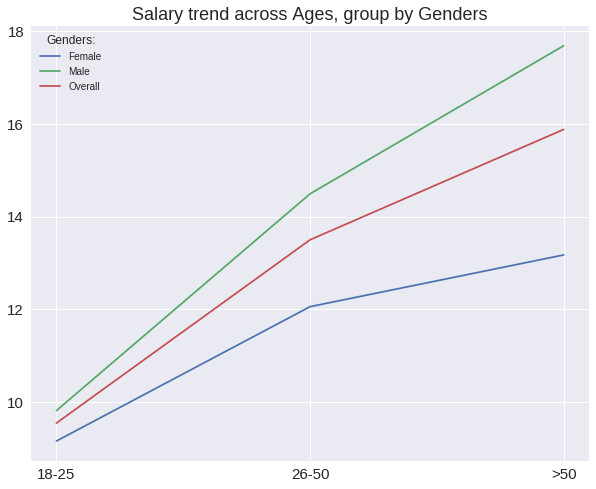

In [13]:
# salary acrosses gender & age groups
# [overall 18-25, o26-50, o>50, female 18-25, f26-50, f>50, male 18-25, m26-50, m>50]
avg_gender_age_salary = [salary_df[x].mean() for x in salary_df.columns[17:]]

index = ['18-25','26-50','>50']

gender_age_df = pd.DataFrame({
    'Overall':avg_gender_age_salary[:3],
    'Female':avg_gender_age_salary[3:6],
    'Male':avg_gender_age_salary[6:]},index=index)

fig,ax = plt.subplots(figsize=(10,8))
ax.set_title(label = "Salary trend across Ages, group by Genders",fontsize=18)
ax.legend(title='Genders:')
gender_age_plot = gender_age_df.plot.line(rot=0,fontsize = 15,ax=ax)
gender_age_plot.set_xticks(np.arange(len(index)))
gender_age_plot.set_xticklabels(index)

### 2.2 Salary trend across Positions, group by Genders
 <a id='section2.2'></a>
 

No handles with labels found to put in legend.


[Text(0, 0, 'Worker'),
 Text(0, 0, 'Employee'),
 Text(0, 0, 'Middle Manager'),
 Text(0, 0, 'Executive')]

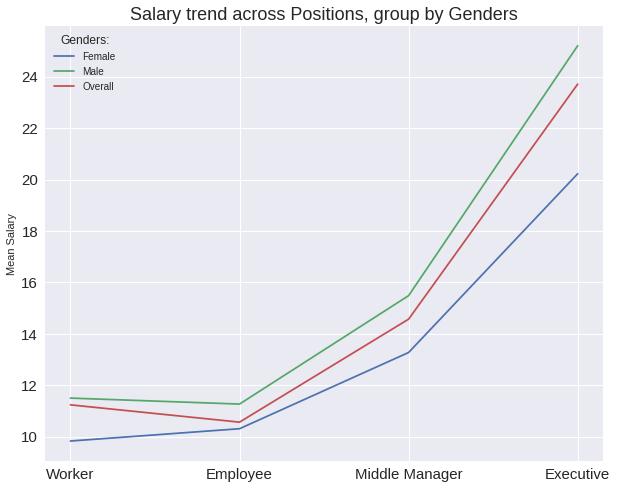

In [14]:
# salary trend acrosses positions, group by genders
overall = [salary_df[x].mean() for x in salary_df.columns[6:2:-1]]
female = [salary_df[x].mean() for x in salary_df.columns[11:7:-1]]
male = [salary_df[x].mean() for x in salary_df.columns[16:12:-1]]

index = ['Worker','Employee','Middle Manager','Executive']

gender_position_df = pd.DataFrame({
    'Overall':overall,
    'Female':female,
    'Male':male},index=index)
fig,ax = plt.subplots(figsize=(10,8))
ax.set_title(label = "Salary trend across Positions, group by Genders",fontsize=18)
ax.legend(title='Genders:')
plt.ylabel("Mean Salary")
gender_pos_plot = gender_position_df.plot.line(rot=0,ax=ax,fontsize=15)
gender_pos_plot.set_xticks(np.arange(len(index)))
gender_pos_plot.set_xticklabels(index)


### 2.3 Salary Distribution across Genders
<a href='section2.3'></a>

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Propotion of population')

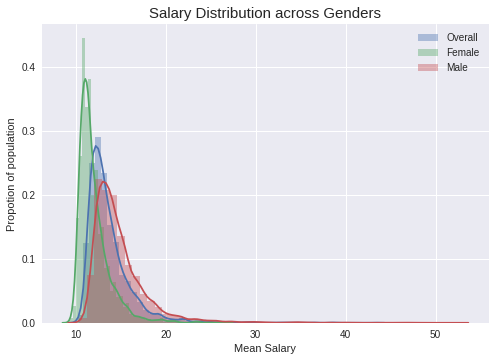

In [15]:
# plot distribution of overall mean salary, female mean salary and male mean salary

sns.set(color_codes=True)
avg_salary_df = salary_df[['SNHM14','SNHMF14','SNHMH14']]

for col in avg_salary_df.columns:
    sns.distplot(avg_salary_df[col])
    
plt.title("Salary Distribution across Genders",fontsize=15)
plt.legend(['Overall','Female',"Male"])
plt.xlabel("Mean Salary")
plt.ylabel('Propotion of population')

## 3. EDA on Firm Data
<a href='section3'></a>

In [16]:
firm_df.describe()

,CODGEO,REG,E14TST,E14TS0ND,E14TS1,E14TS6,E14TS10,E14TS20,E14TS50,E14TS100,E14TS200,E14TS500
count,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000
mean,46521.041051,48.973459,123.721704,83.713829,27.346659,5.237218,3.814956,2.308004,0.743317,0.334627,0.174197,0.048897
std,25513.105550,25.185044,2364.619186,1738.182920,434.069122,84.078419,61.250534,32.753222,9.929839,4.873106,2.797187,1.096414
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25269.000000,25.000000,8.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49159.000000,43.000000,19.000000,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67106.000000,73.000000,54.000000,39.000000,11.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,97617.000000,93.000000,427385.000000,316603.000000,76368.000000,14836.000000,10829.000000,5643.000000,1658.000000,812.000000,456.000000,180.000000


### 3.1 Correlation matrix among firm sizes and salary
<a href='section3.1'></a>

In [0]:
firm_salary_df = firm_df.drop(['LIBGEO','REG','DEP'],axis=1)
firm_salary_df = firm_salary_df.merge(salary_df,how='left',left_on='CODGEO',right_on='CODGEO')

In [0]:
firm_salary_df.dropna(subset=['SNHM14'],inplace=True)

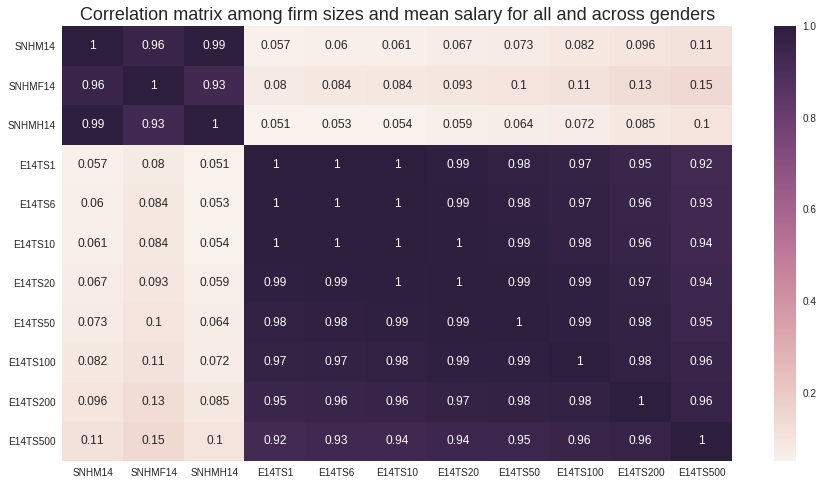

In [262]:
overall_col = ['SNHM14','SNHMF14',"SNHMH14"]+list(firm_df.columns[6:]) 
fig,ax = plt.subplots(figsize=(15,8))
ax.set_title("Correlation matrix among firm sizes and mean salary for all and across genders",fontsize=18)
sns.heatmap(firm_salary_df[overall_col].corr(),annot=True,ax=ax)

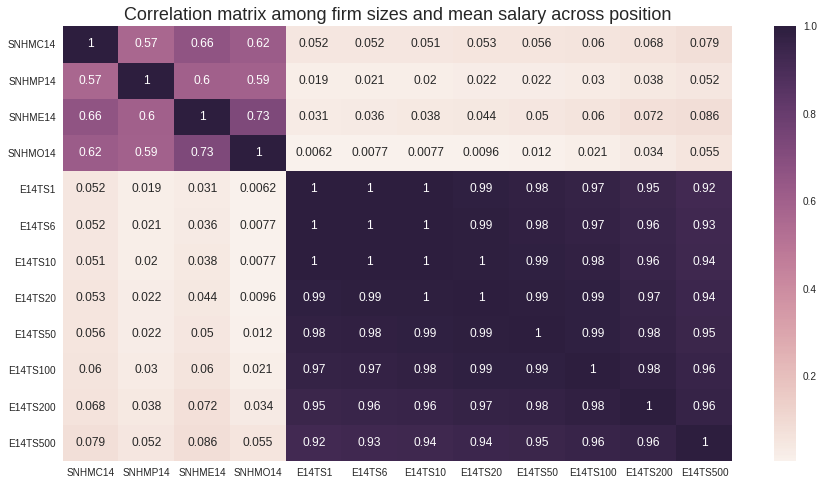

In [259]:
overall_col = ['SNHMC14','SNHMP14',"SNHME14","SNHMO14"]+list(firm_df.columns[6:]) 
fig,ax = plt.subplots(figsize=(15,8))
ax.set_title("Correlation matrix among firm sizes and mean salary across position",fontsize=18)
sns.heatmap(firm_salary_df[overall_col].corr(),annot=True,ax=ax)

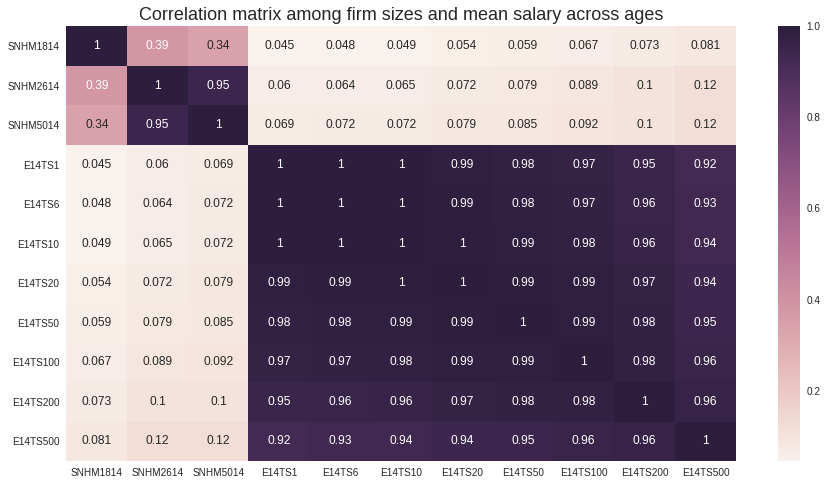

In [260]:
overall_col = ['SNHM1814','SNHM2614',"SNHM5014"]+list(firm_df.columns[6:]) 
fig,ax = plt.subplots(figsize=(15,8))
ax.set_title("Correlation matrix among firm sizes and mean salary across ages",fontsize=18)
sns.heatmap(firm_salary_df[overall_col].corr(),annot=True,ax=ax)

### 3.2 firms distribution

In [0]:
aggregated_firm_df = firm_df.sum()

In [0]:
firm_dist_df = pd.DataFrame({'total':aggregated_firm_df.values[6:]},index=aggregated_firm_df.index[6:])

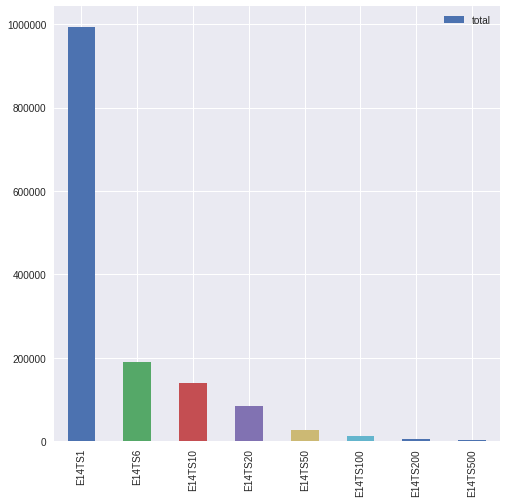

In [110]:
fig,ax = plt.subplots(figsize=(8,8))
firm_dist_df.plot(kind='bar',y='total',ax=ax)

## 4. Correlation Matrix and Decision Tree Regression: Gender, Position vs Salary
<a href='section4'></a>

### 4.1 Correlation matrix: Gender, Position & Salary
<a href='section4.1'></a>

In [0]:
gender_pos_dict={}
gender_pos_dict["SNHMFC14"] = {"gender": 2, "position": 4}
gender_pos_dict["SNHMFP14"] = {"gender": 2, "position": 3}
gender_pos_dict["SNHMFE14"] = {"gender": 2, "position": 2}
gender_pos_dict["SNHMFO14"] = {"gender": 2, "position": 1}
gender_pos_dict["SNHMHC14"] = {"gender": 1, "position": 4}
gender_pos_dict["SNHMHP14"] = {"gender": 1, "position": 3}
gender_pos_dict["SNHMHE14"] = {"gender": 1, "position": 2}
gender_pos_dict["SNHMHO14"] = {"gender": 1, "position": 1}

# compile with gender_position
gp_compiled_data = []
for index, row in salary_df.iterrows():
    for key, value in gender_pos_dict.items(): 
        row_dict = {}
        row_dict["CODGEO"] = row["CODGEO"]
        row_dict["gender"] = value["gender"]
        row_dict["position"] = value["position"]
        row_dict["salary"] = row[key]
        gp_compiled_data.append(row_dict)

In [0]:
gp_compiled_df = pd.DataFrame(gp_compiled_data)

Text(0.5, 1.0, 'Correlation matrix among gender, position and salary')

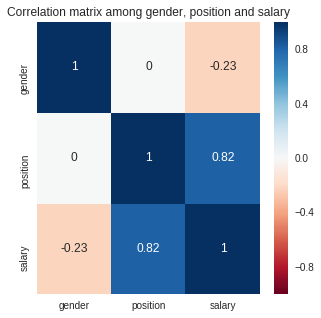

In [287]:
fig, ax = plt.subplots(figsize=(5,5))      
sns.heatmap(gp_compiled_df.drop(['CODGEO'],axis=1).corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)
ax.set_title(label='Correlation matrix among gender, position and salary', fontsize = 12)

### 4.2 Decision Tree Regressor of Gender, Position on Salary
<a href='section4.2'></a>

In [0]:
gp_compiled_df_reg =  gp_compiled_df.drop(['CODGEO'],axis=1)

In [0]:
X = gp_compiled_df_reg.iloc[:, :-1].values
y = gp_compiled_df_reg.iloc[:,-1].values
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
dt_reg = tree.DecisionTreeRegressor()
dt_reg = dt_reg.fit(X_train, y_train)

In [0]:
y_pred = dt_reg.predict(X_test)

In [294]:
r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred)

(0.8814698156526084, 3.4148657325828604)

## 5. Correlation Matrix and Decision Tree Regression: Gender, Age vs Salary
<a href='section5'></a>

### 5.1 Correlation Matrix: Gender, Age, Salary
<a href='section5.1'></a>

In [0]:
gender_age_dict={}
gender_age_dict["SNHMF1814"] = {"gender": 2, "age_group": 1}
gender_age_dict["SNHMF2614"] = {"gender": 2, "age_group": 2}
gender_age_dict["SNHMF5014"] = {"gender": 2, "age_group": 3}
gender_age_dict["SNHMH1814"] = {"gender": 1, "age_group": 1}
gender_age_dict["SNHMH2614"] = {"gender": 1, "age_group": 2}
gender_age_dict["SNHMH5014"] = {"gender": 1, "age_group": 3}

# compile with gender_position
ga_compiled_data = []
for index, row in salary_df.iterrows():
    for key, value in gender_age_dict.items(): 
        row_dict = {}
        row_dict["CODGEO"] = row["CODGEO"]
        row_dict["gender"] = value["gender"]
        row_dict["age_group"] = value["age_group"]
        row_dict["salary"] = row[key]
        ga_compiled_data.append(row_dict)

In [0]:
ga_compiled_df = pd.DataFrame(ga_compiled_data)    

Text(0.5, 1.0, 'Correlation matrix among gender, age and salary')

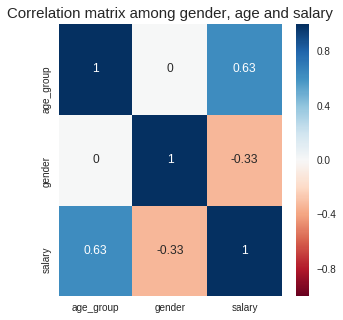

In [336]:
fig, ax = plt.subplots(figsize=(5,5))      
sns.heatmap(ga_compiled_df.drop(['CODGEO'],axis=1).corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)
ax.set_title(label="Correlation matrix among gender, age and salary",fontsize=15)

### 5.2 Decision Tree Regressor of Gender, Age on Salary 
<a href='section5.2'></a>

In [0]:
ga_compiled_df_reg =  ga_compiled_df.drop(['CODGEO'],axis=1)

In [0]:
X = ga_compiled_df.iloc[:, :-1].values
y = ga_compiled_df.iloc[:,-1].values
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
dt_reg = tree.DecisionTreeRegressor()
dt_reg = dt_reg.fit(X_train, y_train)

In [0]:
y_pred = dt_reg.predict(X_test)

In [314]:
r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred)

(0.47722763438431903, 7.533258280306738)

## 6. Random Forest Regressor
<a href='section6'></a>


Combine age_group, MOCO, gender, firm_size, position together to predict salary

In [0]:
population_df_combined_reg = population_df.copy()

In [0]:
population_df_combined_reg = population_df_combined_reg.drop(population_df_combined_reg[population_df_combined_reg['AGEQ80_17']<20].index,axis=0)
population_df_combined_reg = population_df_combined_reg.drop(population_df_combined_reg[population_df_combined_reg['NB']==0].index,axis=0)

In [0]:
population_df_combined_reg['age_group'] =3 
population_df_combined_reg.loc[population_df_combined_reg['AGEQ80_17']==20,['age_group']] = 1
population_df_combined_reg.loc[(population_df_combined_reg.AGEQ80_17>20) & (population_df_combined_reg.AGEQ80_17<=50),['age_group']] = 2

In [0]:
# merge salary_df with population_df_combined_reg
# all_compiled_df = gp_compiled_df.drop(['gender_position'],axis=1)
all_compiled_df = gp_compiled_df.merge(population_df_combined_reg,how='left',left_on='CODGEO',right_on='CODGEO')

In [0]:
nb_col = all_compiled_df['NB']
all_compiled_df = all_compiled_df.drop(['NB'],axis=1)
all_compiled_df['NB'] = nb_col

In [0]:
all_compiled_df = all_compiled_df.drop(all_compiled_df[all_compiled_df['gender']!=all_compiled_df['SEXE']].index)
all_compiled_df = all_compiled_df.drop(["AGEQ80_17","SEXE"],axis = 1)

In [0]:
# merge rows with the same age_group
all_compiled_df = all_compiled_df.groupby(list(all_compiled_df.columns[:-1]),as_index=False).sum()

In [0]:
all_compiled_df[["MOCO","NB",'age_group']]=all_compiled_df[["MOCO","NB","age_group"]].astype(int)

In [0]:
# merge with firm_df
all_compiled_df= all_compiled_df.merge(firm_df,how='left',left_on='CODGEO',right_on='CODGEO')

In [0]:
# re-arrange for train_test split
salary_col = all_compiled_df['salary']
all_compiled_df = all_compiled_df.drop(['salary'],axis=1)
all_compiled_df['salary'] = salary_col

In [0]:
all_compiled_df = all_compiled_df.drop(['CODGEO',"LIBGEO","REG","DEP","gender_position"],axis=1)

In [0]:
X = all_compiled_df.iloc[:, :-1].values
y = all_compiled_df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
rf_reg =RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10) .fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [332]:
r2,mse

(0.8848170328494626, 3.4393365065124026)

## 7. Salary distribution in different departments
  <a href='section7'></a>


In [0]:
salary_town_df = salary_df.merge(town_df,how='left',left_on='CODGEO',right_on="code_insee")

In [0]:
salary_town_df.dropna(subset=['latitude','longitude'],inplace=True)

In [0]:
# create a df of each dept salary
salary_dept_df = salary_town_df.groupby('numéro_département',as_index=False).mean()

In [0]:
# merge with department_df for plotting 
salary_dept_geo = gpd.GeoDataFrame(salary_dept_df.merge(department_df,how='left',left_on='numéro_département',right_on='code'))

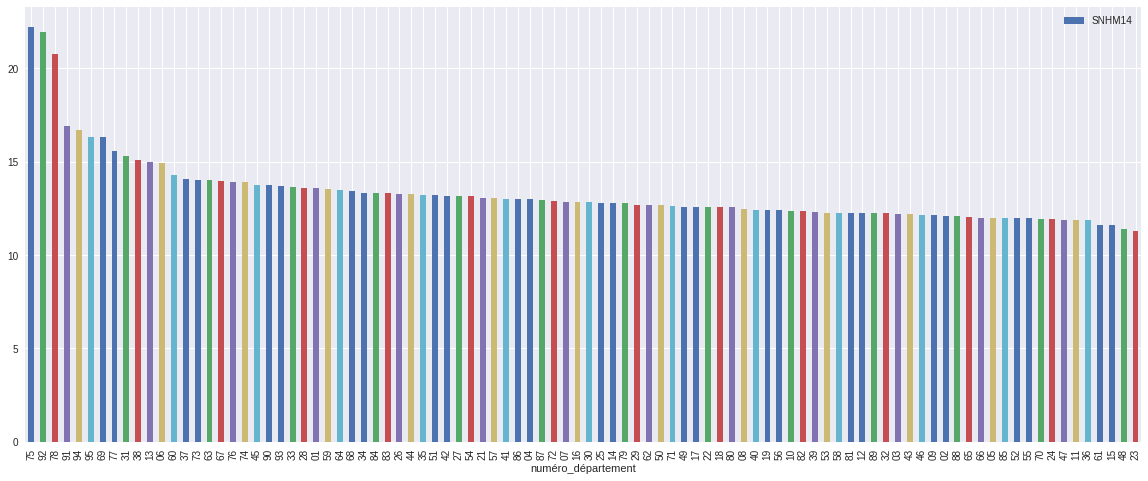

In [258]:
salary_dept_df.sort_values(by='SNHM14',axis=0,ascending=False).plot.bar(x='numéro_département',y='SNHM14',figsize=(20,8))

In [206]:
# find the top three departments with highest mean salary (way higher than the rest)
department_df.loc[department_df.code.isin(['75','92','78'])]

,code,nom,geometry
36,75,Paris,"POLYGON ((2.319887 48.90046, 2.329981 48.90116..."
37,78,Yvelines,"POLYGON ((2.200591 48.908679, 2.176518 48.9003..."
44,92,Hauts-de-Seine,"POLYGON ((2.290969 48.950966, 2.30198 48.95014..."


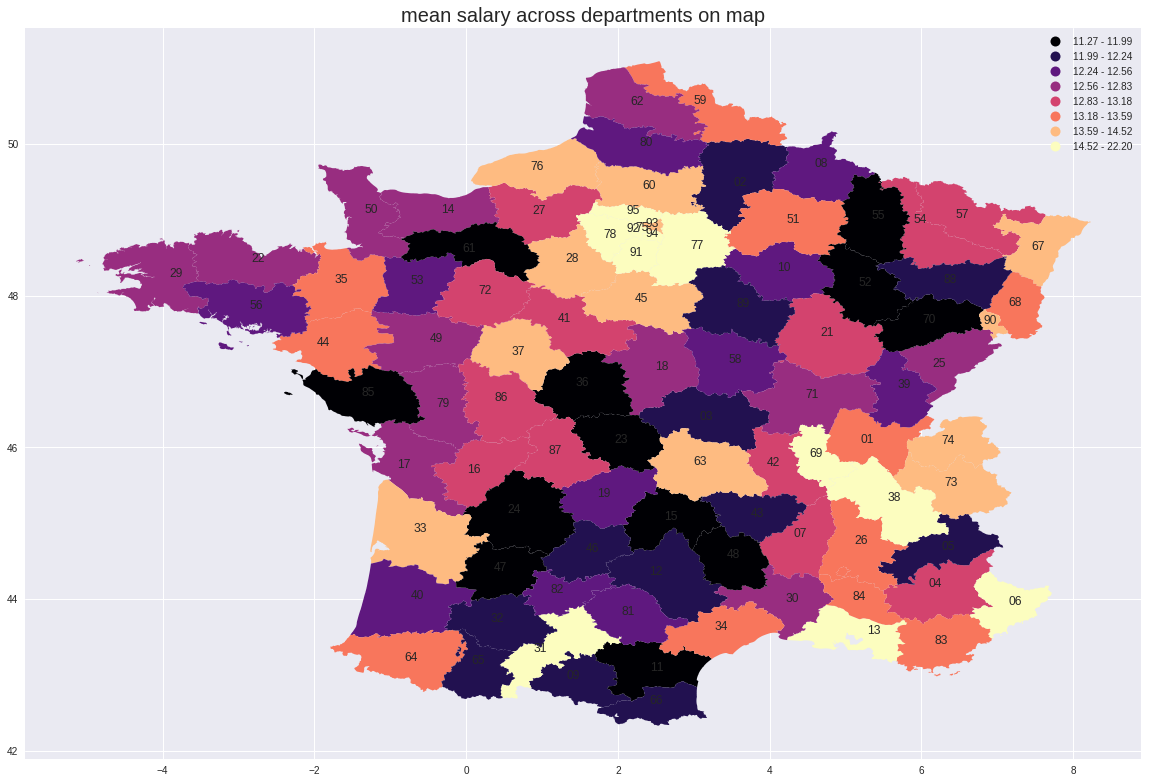

In [391]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_title(label='mean salary across departments on map',fontsize= 20)
salary_dept_plot = salary_dept_geo.plot(column='SNHM14',cmap='magma',legend=True,ax=ax,scheme='quantiles',k=8)
for idx, row in department_df.iterrows():
    plt.annotate(s=row['code'], xy=row['coords'],
                 horizontalalignment='center')

## 8. Male-Female ratio in different departments
  <a href='section8'></a>


### 8.1 Visualization of MF ratio on map
<a href='#section8.1'></a>

In [0]:
population_gender_dist_df = population_df.copy()
population_gender_dist_df = population_gender_dist_df.groupby(['CODGEO',"SEXE"],as_index=False).sum()
population_gender_dist_df = population_gender_dist_df.drop(['MOCO',"AGEQ80_17"],axis=1)

In [0]:
population_gender_dist_pivot_table = population_gender_dist_df.pivot_table(index='CODGEO',values='NB',columns='SEXE')
population_gender_dist_pivot_table['MF_ratio'] = population_gender_dist_pivot_table[1] / population_gender_dist_pivot_table[2]
population_gender_dist_pivot_table['CODGEO'] = population_gender_dist_pivot_table.index

In [0]:
# remove inf and NaN
population_gender_dist_pivot_table.loc[population_gender_dist_pivot_table[2]==0,['MF_ratio']]=0

In [0]:
mf_town_df = population_gender_dist_pivot_table.merge(town_df,how='left',left_on='CODGEO',right_on="code_insee")

In [0]:
mf_town_df.dropna(subset=['latitude','longitude'],inplace=True)

In [0]:
mf_dept_df = mf_town_df.groupby(['numéro_département'],as_index=False).mean()

In [0]:
# merge with department_df for plotting 
mf_dept_geo = gpd.GeoDataFrame(mf_dept_df.merge(department_df,how='left',left_on='numéro_département',right_on='code'))

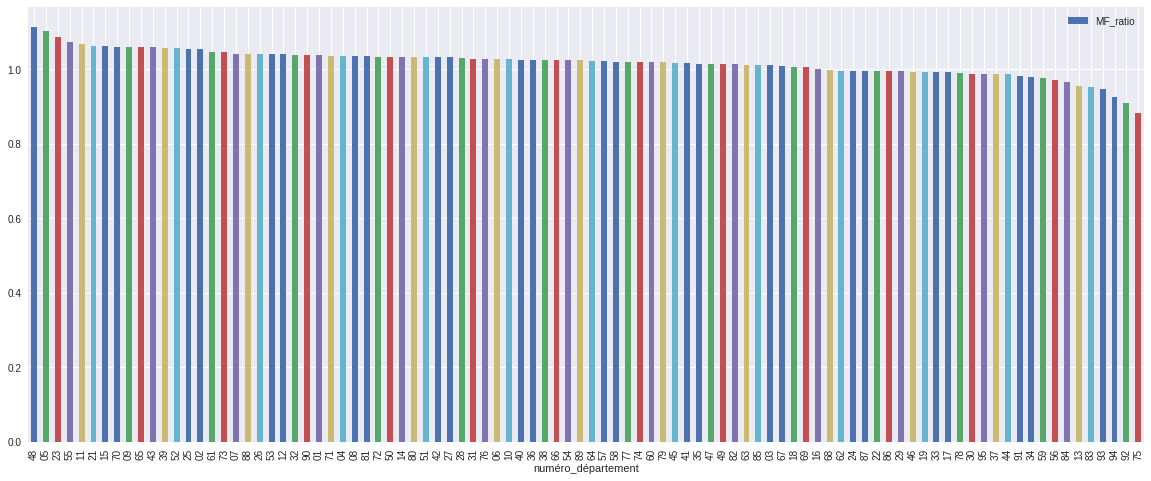

In [382]:
mf_dept_df.sort_values(by='MF_ratio',axis=0,ascending=False).plot.bar(x='numéro_département',y='MF_ratio',figsize=(20,8))

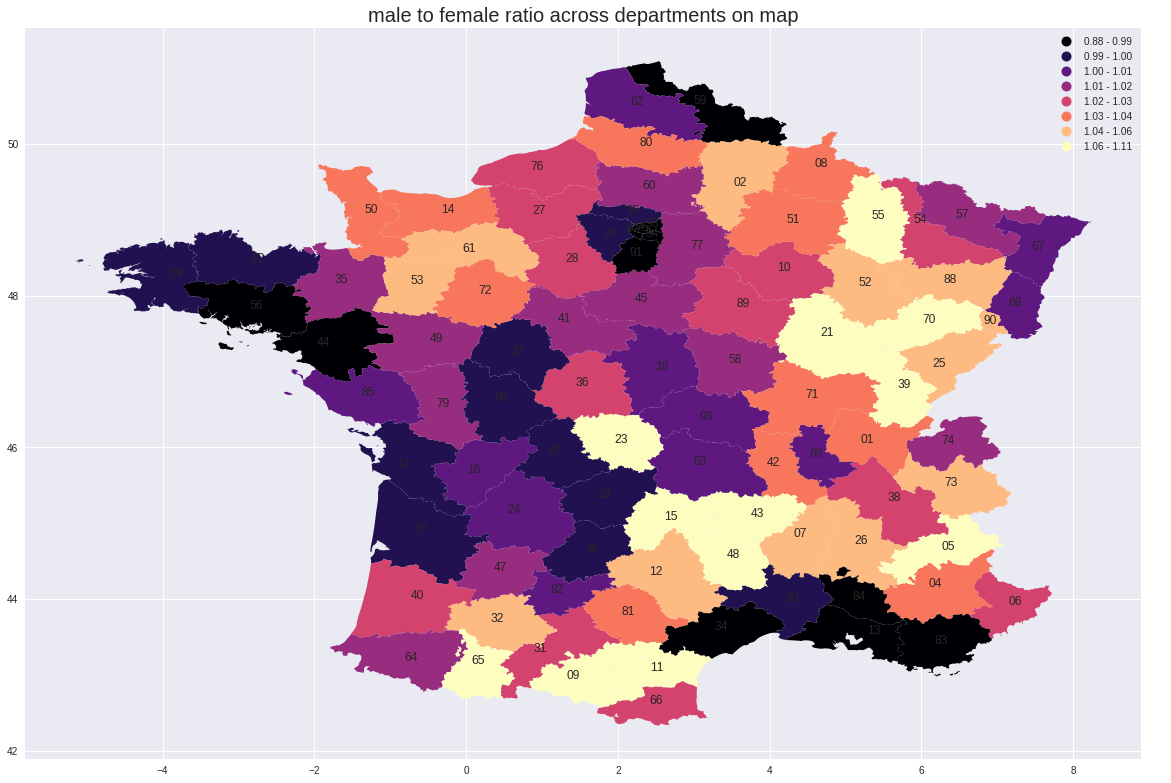

In [392]:
fig,ax = plt.subplots(figsize=(20,20)) 
ax.set_title(label='male to female ratio across departments on map',fontsize= 20)
mf_dept_plot = mf_dept_geo.plot(column='MF_ratio',cmap='magma',legend=True,ax=ax,scheme='quantiles',k=8)

for idx, row in department_df.iterrows():
    plt.annotate(s=row['code'], xy=row['coords'],
                 horizontalalignment='center')

### 8.2 Correlation between MF ratio and salaries
<a href='#section8.2'></a>

In [0]:
mf_salary_df = mf_town_df[['MF_ratio',"CODGEO",'numéro_département']].merge(salary_df,how='left',left_on='CODGEO',right_on="CODGEO")

In [0]:
mf_salary_df.dropna(subset=['SNHM14'],inplace=True)

In [338]:
mf_salary_df[["MF_ratio","SNHM14"]].corr()

,MF_ratio,SNHM14
MF_ratio,1.000000,0.061425
SNHM14,0.061425,1.000000


In [340]:
mf_salary_df[["MF_ratio","SNHMC14","SNHMP14","SNHME14","SNHMO14"]].corr()['MF_ratio']

MF_ratio    1.000000
SNHMC14    -0.020824
SNHMP14     0.076748
SNHME14     0.131869
SNHMO14     0.126967
Name: MF_ratio, dtype: float64

In [341]:
mf_salary_df[["MF_ratio","SNHM1814","SNHM2614","SNHM5014"]].corr()['MF_ratio']

MF_ratio    1.000000
SNHM1814    0.038993
SNHM2614    0.085068
SNHM5014    0.021693
Name: MF_ratio, dtype: float64

## 9. Population across ages in different departments
  <a href='section9'></a>



In [0]:
population_age_dist_df = population_df.copy()
population_age_dist_df = population_age_dist_df.groupby(['CODGEO',"AGEQ80_17"],as_index=False).sum()
population_age_dist_df = population_age_dist_df.drop(['MOCO',"SEXE"],axis=1)
population_age_dist_df = population_age_dist_df.drop(population_age_dist_df[population_age_dist_df.NB==0].index,axis=0)
population_age_dist_df = population_age_dist_df.dropna(subset=['NB'],axis=0)

In [0]:
# age group here is different from that in salary
# 1: 0-25 (before working) 2:26-60 (working before retirement) 3: 61-80 (retirement)

population_age_dist_df['age_group'] =2 
population_age_dist_df.loc[population_age_dist_df['AGEQ80_17']<=25,['age_group']] = 1
population_age_dist_df.loc[population_age_dist_df['AGEQ80_17']>60,['age_group']] = 3

In [0]:
population_age_dist_pivot_table = population_age_dist_df.pivot_table(index='CODGEO',values='NB',columns='age_group')
population_age_dist_pivot_table = population_age_dist_pivot_table.fillna(value=0).astype(int)
population_age_dist_pivot_table['CODGEO'] = population_age_dist_pivot_table.index

In [0]:
age_town_tf = population_age_dist_pivot_table.merge(town_df,how='left',left_on='CODGEO',right_on="code_insee")

In [0]:
age_town_tf.dropna(subset=['latitude','longitude'],inplace=True)

In [0]:
age_dept_df = age_town_tf.groupby(['numéro_département'],as_index=False).mean()

In [0]:
age_dept_df.drop(['code_région','CODGEO','numéro_circonscription','code_insee','éloignement'],axis=1,inplace=True)

In [224]:
age_dept_df.drop(['numéro_département','latitude','longitude'],axis=1).corr()

,1,2,3
1,1.000000,0.999990,0.999928
2,0.999990,1.000000,0.999955
3,0.999928,0.999955,1.000000


Legend: red: >60; blue: <=25; green: 26-60


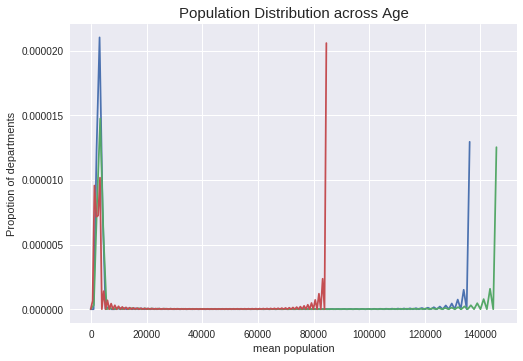

In [362]:
for i in range (1,4):
    sns.distplot(age_dept_df[i],hist=False)
        
plt.title("Population Distribution across Age",fontsize=15)
#
plt.xlabel("mean population")
plt.ylabel('Propotion of departments')

print('Legend: red: >60;',"blue: <=25;", "green: 26-60")

In [0]:
age_dept_df['total'] = age_dept_df[1] + age_dept_df[2] + age_dept_df[3]

In [0]:
age_dept_geo = gpd.GeoDataFrame(age_dept_df.merge(department_df,how='left',left_on='numéro_département',right_on='code'))

In [0]:
department_df['coords'] = department_df['geometry'].apply(lambda x: x.representative_point().coords[:])
department_df['coords'] = [coords[0] for coords in department_df['coords']]

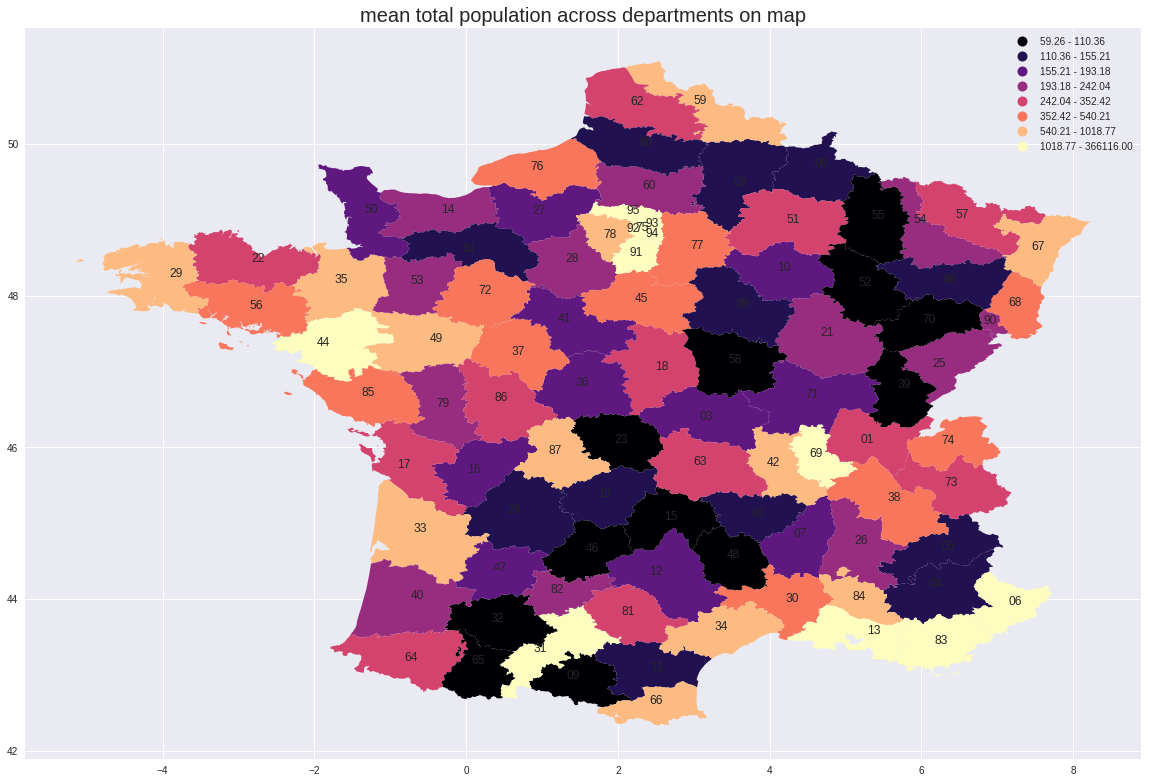

In [386]:
fig,ax = plt.subplots(figsize=(20,20)) 
ax.set_title(label='mean total population across departments on map',fontsize= 20)
age_dept_plot = age_dept_geo.plot(column='total',cmap='magma',legend=True,ax=ax,scheme='quantiles',k=8)
for idx, row in department_df.iterrows():
    plt.annotate(s=row['code'], xy=row['coords'],
                 horizontalalignment='center')